In [4]:
import os
import pickle

import music21
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [138]:
pieces = music21.corpus.getComposer('palestrina')

First, parse all the scores and save them as pickled files

In [3]:
# scores = [ music21.corpus.parse(piece) for piece in tqdm(pieces) ]

100%|██████████| 1318/1318 [14:56<00:00,  1.47it/s]


In [62]:
len(scores)

1318

pickle the scores for later use

In [23]:
# for i, score in enumerate(tqdm(scores)):
#     with open('scores/{}.pkl'.format(os.path.basename(pieces[i])), 'wb') as score_file:
#         pickle.dump(score, score_file)

100%|██████████| 1318/1318 [02:03<00:00, 10.70it/s]


load from the pickles

In [6]:
scores = []
for path in tqdm(os.listdir('scores')):
    with open('scores/' + path, 'rb') as score_pickle:
        scores.append(pickle.load(score_pickle))

100%|██████████| 1318/1318 [01:27<00:00, 15.09it/s]


Now let's take a look at the distribution of parts

In [7]:
def nb_parts(score):
    return len(list(filter(lambda x: isinstance(x, music21.stream.Part), score)))

In [8]:
parts = np.array([nb_parts(score) for score in tqdm(scores)])

100%|██████████| 1318/1318 [00:04<00:00, 302.35it/s]


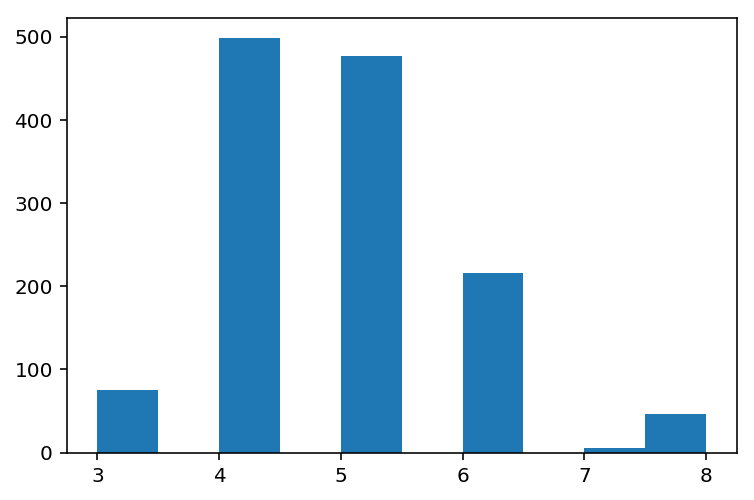

In [9]:
plt.hist(parts)
plt.show()

Now, let's look at the distribution of keys

In [10]:
keys = [s.analyze('key') for s in tqdm(scores)]

100%|██████████| 1318/1318 [02:19<00:00,  9.42it/s]


In [11]:
tonics = [k.tonic.fullName for k in keys]

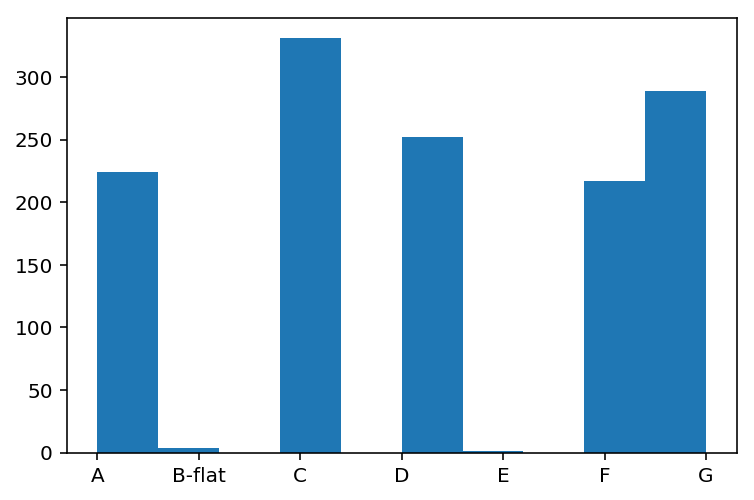

In [12]:
plt.hist(tonics)
plt.show()

In [13]:
len(np.unique(tonics))

7

In [23]:
len(np.unique(tonics)) * len(scores)

9226

In [24]:
12 * len(scores)

15816

Let's look at the notes in a score and figure out how to vectorize it.

In [25]:
s = scores[0]

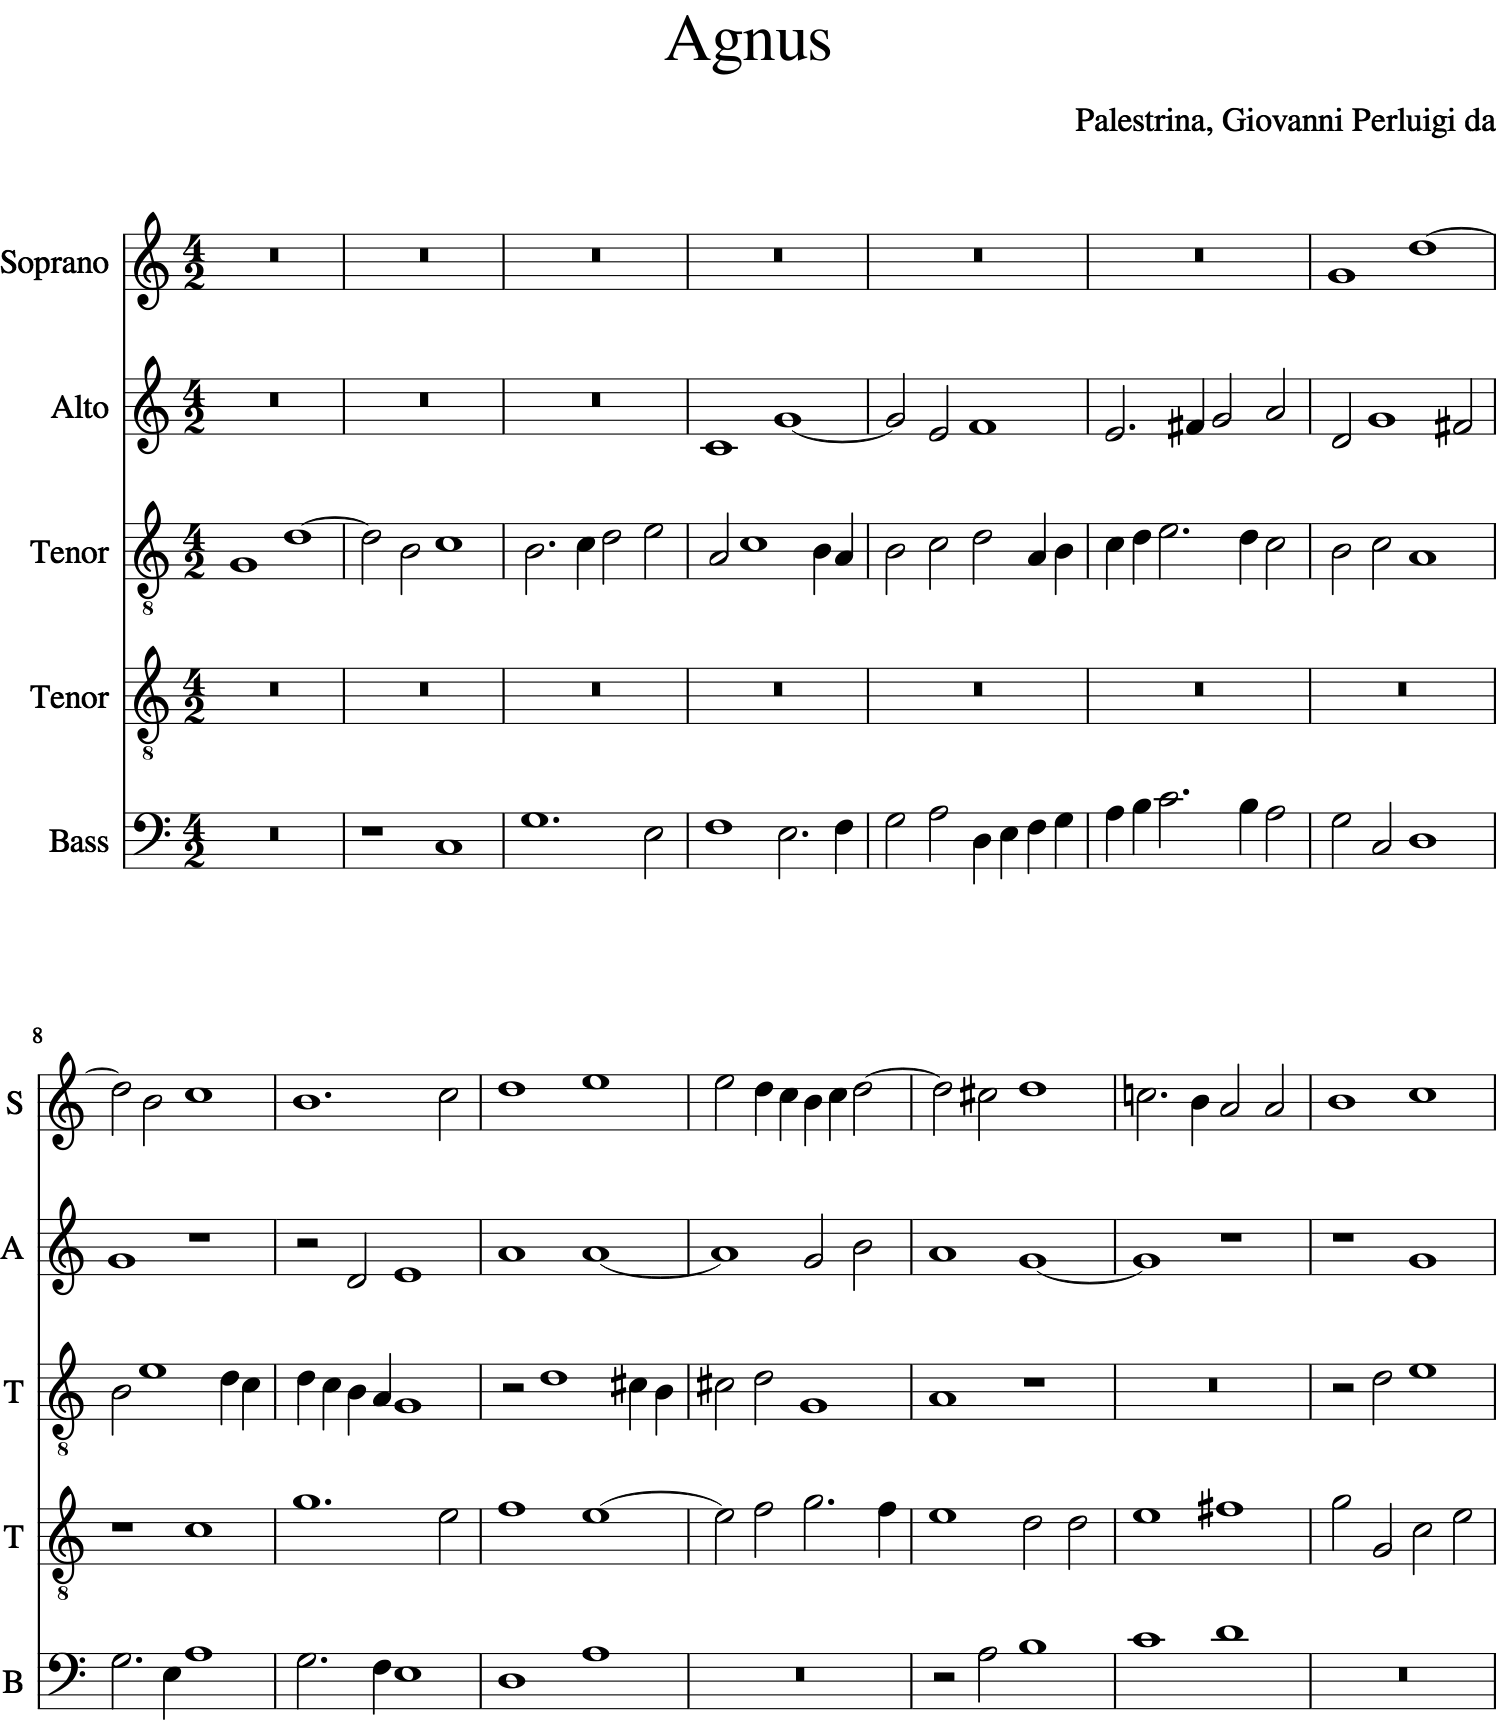

In [26]:
s.show()

In [27]:
list(s)

 <music21.stream.Part spine_4>,
 <music21.stream.Part spine_3>,
 <music21.stream.Part spine_2>,
 <music21.stream.Part spine_1>,
 <music21.stream.Part spine_0>,
 <music21.humdrum.spineParser.GlobalReference CDT "1525/^1526/-1594/2/2">,
 <music21.humdrum.spineParser.GlobalReference AGN "Mass (Paraphrase)">,
 <music21.humdrum.spineParser.GlobalReference AST "renaissance, vocal">,
 <music21.humdrum.spineParser.GlobalReference ASW "Gregorian Mass">,
 <music21.humdrum.spineParser.GlobalReference PWK "Masses, Book Mantuan I">,
 <music21.humdrum.spineParser.GlobalReference RNB "Cadence finals: D">,
 <music21.humdrum.spineParser.GlobalReference YOR "Le Opere Complete, v. 18, p. 83">,
 <music21.humdrum.spineParser.GlobalReference END "1992//">,
 <music21.humdrum.spineParser.GlobalReference YEN "United States of America">,
 <music21.humdrum.spineParser.GlobalReference YEM "Rights to all derivative electronic formats reserved.">,
 <music21.humdrum.spineParser.GlobalReference YEM "Refer to licensin

In [28]:
parts = list(s.getElementsByClass(music21.stream.Part))

In [29]:
p = parts[0]

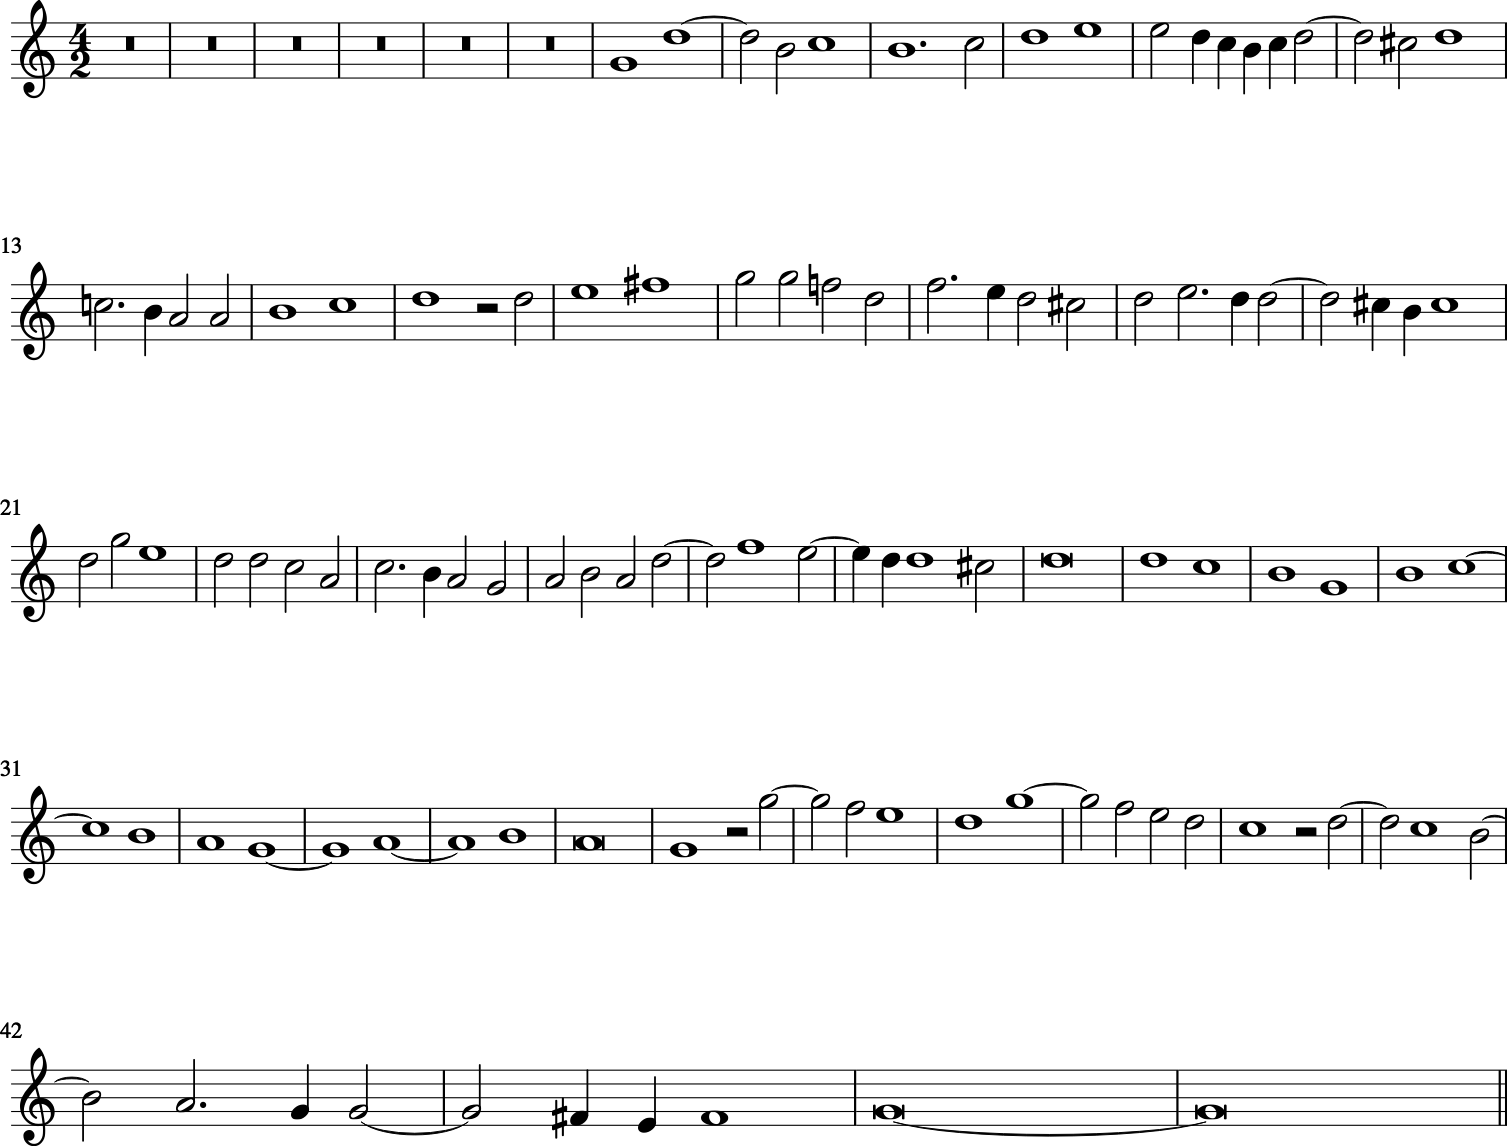

In [30]:
p.show()

In [58]:
list(p)

[<music21.humdrum.spineParser.MiscTandem **kern humdrum control>,
 <music21.humdrum.spineParser.MiscTandem *G:mix humdrum control>,
 <music21.stream.Measure 1 offset=0.0>,
 <music21.stream.Measure 2 offset=8.0>,
 <music21.stream.Measure 3 offset=16.0>,
 <music21.stream.Measure 4 offset=24.0>,
 <music21.stream.Measure 5 offset=32.0>,
 <music21.stream.Measure 6 offset=40.0>,
 <music21.stream.Measure 7 offset=48.0>,
 <music21.stream.Measure 8 offset=56.0>,
 <music21.stream.Measure 9 offset=64.0>,
 <music21.stream.Measure 10 offset=72.0>,
 <music21.stream.Measure 11 offset=80.0>,
 <music21.stream.Measure 12 offset=88.0>,
 <music21.stream.Measure 13 offset=96.0>,
 <music21.stream.Measure 14 offset=104.0>,
 <music21.stream.Measure 15 offset=112.0>,
 <music21.stream.Measure 16 offset=120.0>,
 <music21.stream.Measure 17 offset=128.0>,
 <music21.stream.Measure 18 offset=136.0>,
 <music21.stream.Measure 19 offset=144.0>,
 <music21.stream.Measure 20 offset=152.0>,
 <music21.stream.Measure 21 offs

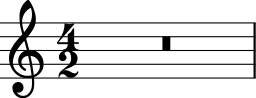

In [31]:
measure1 = p[2]
measure1.show()

In [32]:
measure1.timeSignature

<music21.meter.TimeSignature 4/2>

In [90]:
measure7.offset

56.0

In [39]:
measure7.timeSignature

In [40]:
note = list(measure7)[0]

In [43]:
list(measure7)

[<music21.note.Note D>,
 <music21.note.Note B>,
 <music21.note.Note C>,
 <music21.bar.Barline style=regular>]

In [45]:
note.duration.quarterLength

2.0

look at distribution of note durations

In [102]:
durations = []

In [103]:
for score in tqdm(scores):
    for n in score.flat.elements:
        if n.duration.quarterLength > 0:
            durations.append(n.duration.quarterLength)

100%|██████████| 1318/1318 [00:01<00:00, 727.89it/s]


In [104]:
dur = np.array(durations).astype(float)

In [105]:
np.min(dur)

0.5

In [106]:
np.max(dur)

8.0

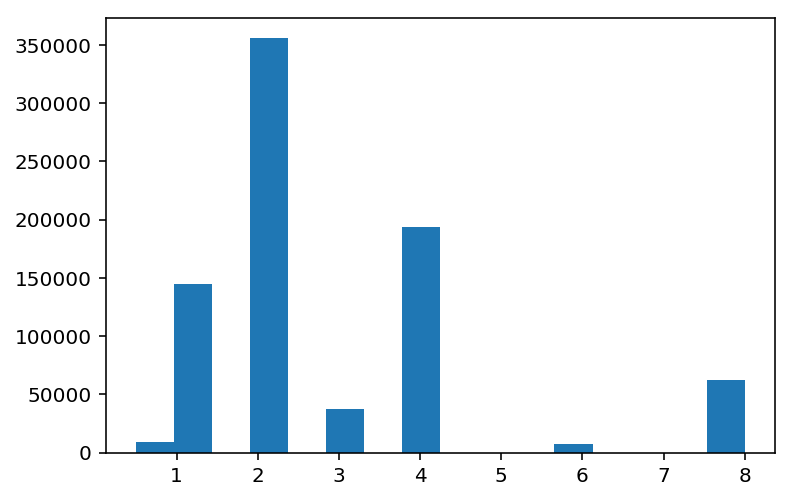

In [107]:
# sample 10k notes
plt.hist(dur, bins=16)
plt.show()

look at score durations

In [118]:
score_lengths = []
for score in tqdm(scores):
    score_lengths.append(score.duration.quarterLength / 8)

100%|██████████| 1318/1318 [00:04<00:00, 321.87it/s]


In [127]:
def get_score_shape(score: music21.stream.Score) -> (int, int):
    n_voices: int = len(score.getElementsByClass(music21.stream.Part))
    n_eighth_notes: int = int(score.duration.quarterLength * 2)
    return n_voices, n_eighth_notes

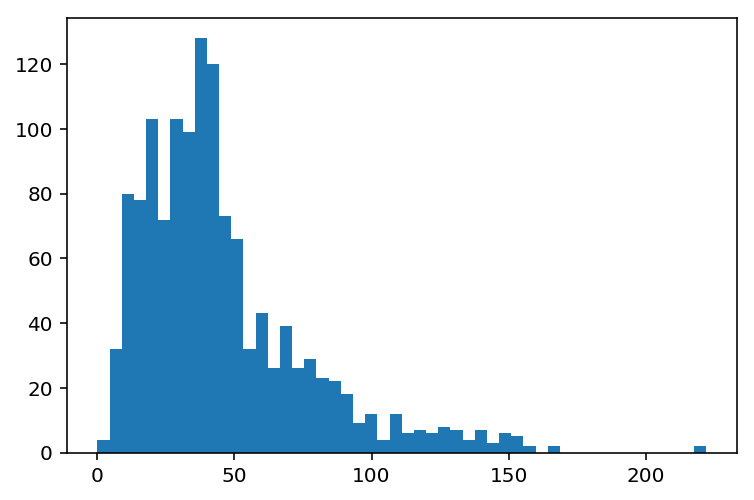

In [128]:
plt.hist(score_lengths, bins=50)
plt.show()

In [129]:
get_score_shape(scores[0])

(5, 720)

In [161]:
score_0 = music21.corpus.parse(pieces[0])

In [228]:
idx_slur = 0
idx_beat = 1
max_beats_per_measure = 16
n_meta_features = 17

def score_to_tensor(score: music21.stream.Score) -> (np.ndarray, np.ndarray):
    n_voices, n_eighths = get_score_shape(score)
    score_tensor = np.zeros((n_voices, n_eighths))
    meta_tensor = np.zeros((n_voices, n_eighths, n_meta_features))
    max_beats_per_measure
    
    for i, part in enumerate(score.getElementsByClass(music21.stream.Part)):
        for measure in part.getElementsByClass(music21.stream.Measure):
            # we're going to multiply all durations by two,
            # because eighth note is the shortest in the corpus.
            beats_in_measure = measure.duration.quarterLength * 2
            # Get the offset of the beginning of the measure (from the beginning of the piece)
            measure_offset = int(measure.offset)
            for b in range(int(beats_in_measure)):
                # Annotate each eighth-note pulse in the metadata track
                meta_tensor[i][measure_offset * 2 + b][idx_beat + b] = 1
            for note in measure.getElementsByClass(music21.note.Note):
                offset = int(note.offset + measure_offset) * 2
                beat = (note.beat - 1) * 2.0
                for j in range(int(offset), int(offset + note.duration.quarterLength * 2)):
                    # mark the note with its midi pitch throughout its duration
                    score_tensor[i][j] = float(note.midi)
                    beat += 1
                    if j > offset:
                        # Add a 'slur' annotation for any held note
                        meta_tensor[i][j][idx_slur] = 1
    return score_tensor, meta_tensor            
    

In [320]:
s, m = score_to_tensor(score_0)

In [321]:
list(scores[0].getElementsByClass(music21.stream.Measure))

[]

In [322]:
np.max([measure.duration.quarterLength 
 for score in scores
 for part in score.getElementsByClass(music21.stream.Part)
 for measure in part.getElementsByClass(music21.stream.Measure)])

8.0

are there meter changes?

In [260]:
measure_lengths_by_score = [[measure.duration.quarterLength 
 for part in score.getElementsByClass(music21.stream.Part)
 for measure in part.getElementsByClass(music21.stream.Measure)] for score in tqdm(scores)]

100%|██████████| 1318/1318 [00:04<00:00, 327.50it/s]


In [265]:
n_unique_measure_lengths_by_score = np.array([
    len(np.unique(measure_lengths))
    for measure_lengths in measure_lengths_by_score
])

In [266]:
np.sum(n_unique_measure_lengths_by_score == 2)

69

In [413]:
def tensor_to_score(score_tensor, meta_tensor):
    # TODO: this seems to create accurate output when played as a midi,
    # but doesn't render the rhythms correctly in musescore.
    # Also, our output will probably have a 
    beats = np.argmax(meta_tensor[:, :, idx_beat:], axis=2)/2
    measure_length = np.max(beats) + 0.5
    score = music21.stream.Score()
    n_parts, n_beats = score_tensor.shape
    measure = None
    for i in range(n_parts):
        part = music21.stream.Part()
        score.insert(0, part)
        for j in range(n_beats):
            if beats[i, j] == 0:
                measure = music21.stream.Measure()
                part.insert(j / 2, measure)
            if score_tensor[i, j] != 0 and meta_tensor[i, j, idx_slur] == 0:
                duration = 0.5
                k = 1
                while j + k < n_beats and meta_tensor[i, j + k, idx_slur] == 1:
                    duration += 0.5
                    k += 1
                note = music21.note.Note(score_tensor[i, j])
                note.duration.quarterLength = duration
                measure.insert(beats[i, j], note)
            elif score_tensor[i, j] == 0 and (j == 0 or score_tensor[i, j - 1] != 0):
                # insert a rest
                duration = 0.5
                k = 1
                while j + k < n_beats and score_tensor[i, j + k] == 0:
                    duration += 0.5
                    k += 1
                rest = music21.note.Rest()
                rest.duration.quarterLength = duration
                measure.insert(beats[i, j], rest)
    return score
        

In [414]:
# music21.corpus.parse(pieces[0]).show('mxl')

In [424]:
s, m = score_to_tensor(score_0)

In [425]:
reconstructed = tensor_to_score(s, m)

In [431]:
reconstructed.write('midi')

'/var/folders/tz/1572h57x6blgvbx33p6nyg3xbw4mw_/T/music21/tmpvo993f0e.mid'

In [432]:
scores[0].write('midi')

'/var/folders/tz/1572h57x6blgvbx33p6nyg3xbw4mw_/T/music21/tmpwu_cj1s9.mid'

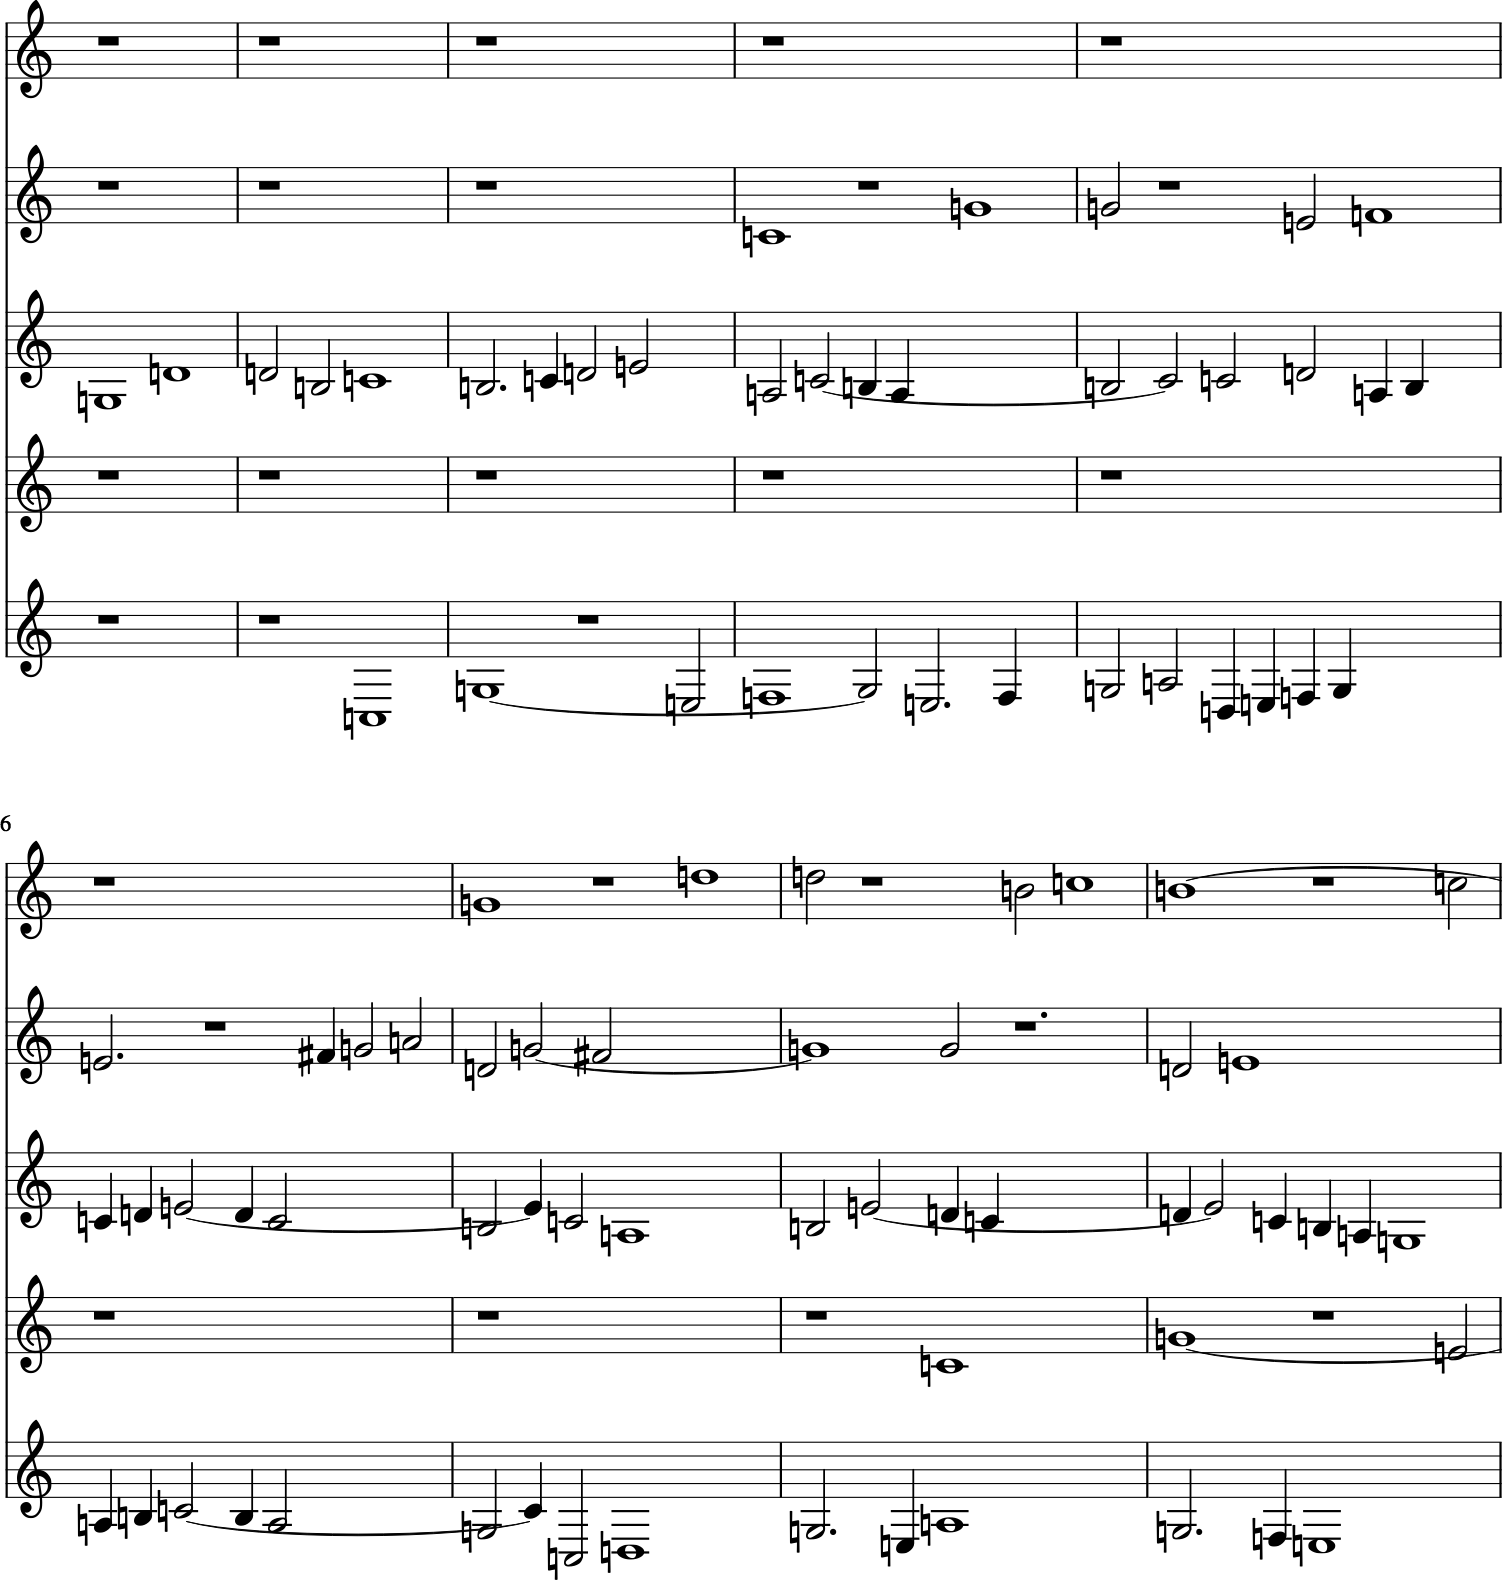

In [428]:
reconstructed.show()

In [430]:
scores[0].show()

SyntaxError: invalid syntax (<ipython-input-430-b69868684d20>, line 1)

In [365]:
score = music21.stream.Score()
note = music21.note.Note(77)

In [366]:
measure = music21.stream.Measure()
measure.duration.quarterLength = 4
score.insert(0, measure)
measure2 = music21.stream.Measure()
measure2.duration.quarterLength = 4
score.insert(4, measure2)

In [367]:
note.duration.quarterLength = 5
measure.insert(0, note)

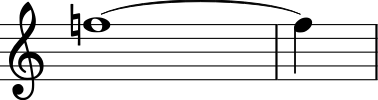

In [368]:
score.show()